In [1]:
%load_ext autoreload
%autoreload 2

import galsim
import numpy as np
import ngmix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

## A Simple Set of Gaussian Blobs

In [220]:
SCALE = 0.25
PSF_FAC = 0.95
DRAW_METH = 'auto'
GFWHM = 1e-6

obj = [
    galsim.Gaussian(fwhm=GFWHM).shift(-12 - SCALE/2, SCALE/2), 
    galsim.Gaussian(fwhm=GFWHM).shift(12 + SCALE/2, SCALE/2)]

pobj = [
    galsim.Convolve(obj[0], galsim.Gaussian(fwhm=PSF_FAC)),
    galsim.Convolve(obj[1], galsim.Gaussian(fwhm=1.00))]

hpobj = [
    galsim.Convolve(obj[0], galsim.Gaussian(fwhm=1.00)),
    galsim.Convolve(obj[1], galsim.Gaussian(fwhm=1.00))]

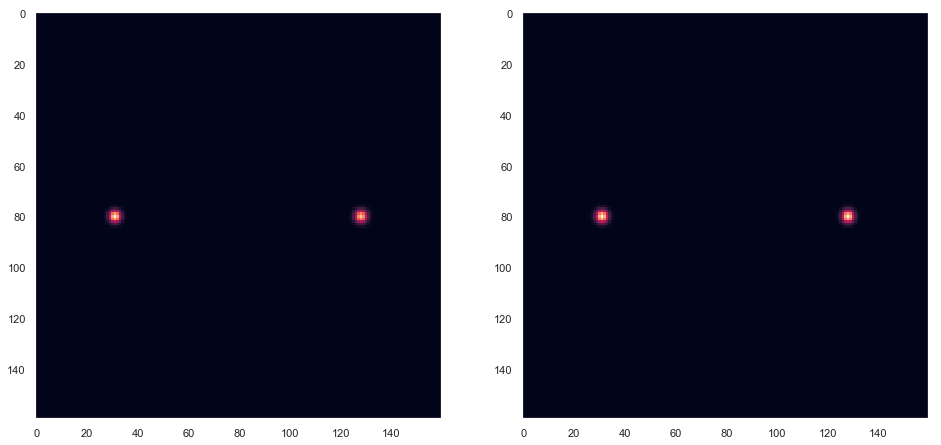

In [221]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax = axs[0]
im = galsim.Sum(pobj).drawImage(scale=SCALE, nx=160, ny=160, method=DRAW_METH)
ax.imshow(im.array)
ax.grid(False)

ax = axs[1]
im = galsim.Sum(hpobj).drawImage(scale=SCALE, nx=160, ny=160, method=DRAW_METH)
ax.imshow(im.array)
ax.grid(False)

In [222]:
def psf_model(row, col):
    if col >= 160/2:
        return galsim.Gaussian(fwhm=1.0).drawImage(scale=SCALE, nx=17, ny=17, method=DRAW_METH).array
    else:
        return galsim.Gaussian(fwhm=PSF_FAC).drawImage(scale=SCALE, nx=17, ny=17, method=DRAW_METH).array

In [223]:
from psf_homogenizer_galsim import PSFHomogenizer

hpsf = PSFHomogenizer(psf_model, [160, 160], patch_size=10)
print(hpsf._target_psf_loc)

(4.5, 84.5)


In [224]:
%%time

im_orig = galsim.Sum(pobj).drawImage(scale=SCALE, nx=160, ny=160, method=DRAW_METH).array

imh = hpsf.homogenize_image(im_orig)

CPU times: user 2.29 s, sys: 23.7 ms, total: 2.31 s
Wall time: 2.33 s


Text(0.5, 1.0, 'image')

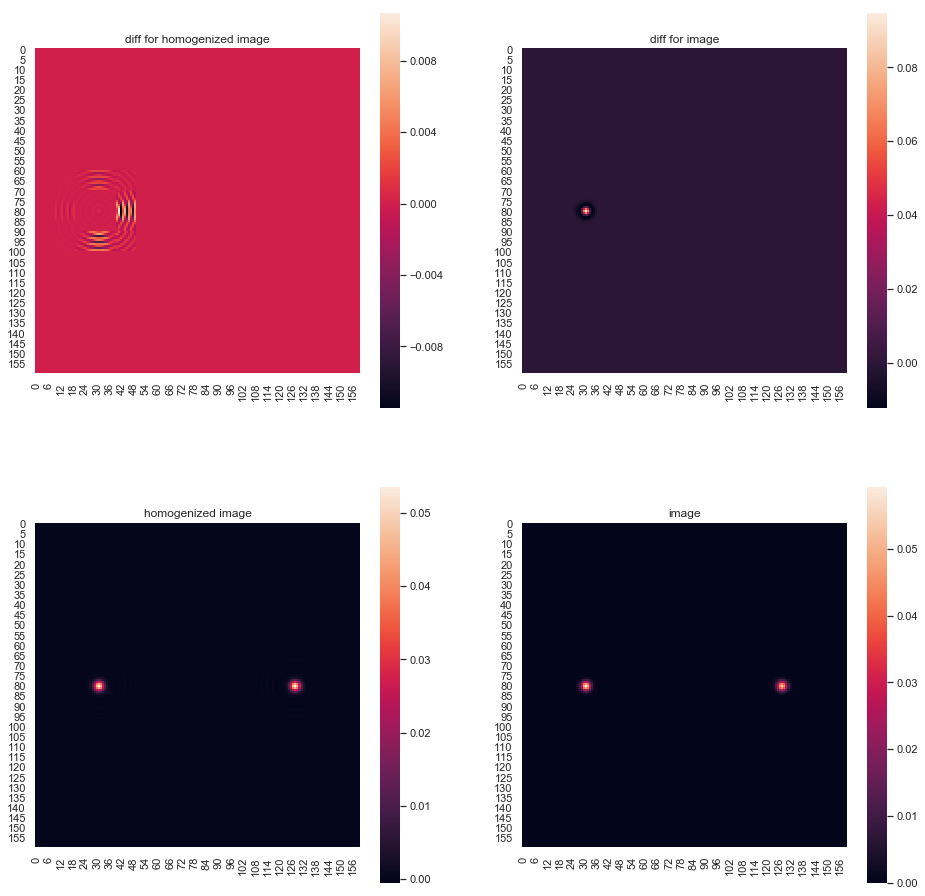

In [225]:
def _subtract_mirrored(im, im_true):
    imn = np.zeros_like(im)
    mid = imn.shape[1] // 2
    imn[:, :mid] = im[:, :mid] - im_true[:, mid:][:, ::-1]
    imn[:, mid:] = im[:, mid:] - im_true[:, mid:]
    return imn


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax = axs[0, 1]
imp = _subtract_mirrored(im_orig, im_orig)
vmin = np.min(imp)
vmax = np.max(imp)
# imp = (imp - vmin) / (vmax - vmin)
imp = imp / im_orig.max()
sns.heatmap(imp, ax=ax, square=True)
ax.grid(False)
ax.set_title('diff for image')

ax = axs[0, 0]
imp = _subtract_mirrored(imh, imh)
imp = (imp)/imh.max() #/(vmax - vmin)
sns.heatmap(imp, ax=ax, square=True)
ax.set_title('diff for homogenized image')

ax = axs[1, 0]
sns.heatmap(imh, ax=ax, square=True)
ax.set_title('homogenized image')

ax = axs[1, 1]
sns.heatmap(im_orig, ax=ax, square=True)
ax.set_title('image')

1.0176572532478152
1.0183233382482502


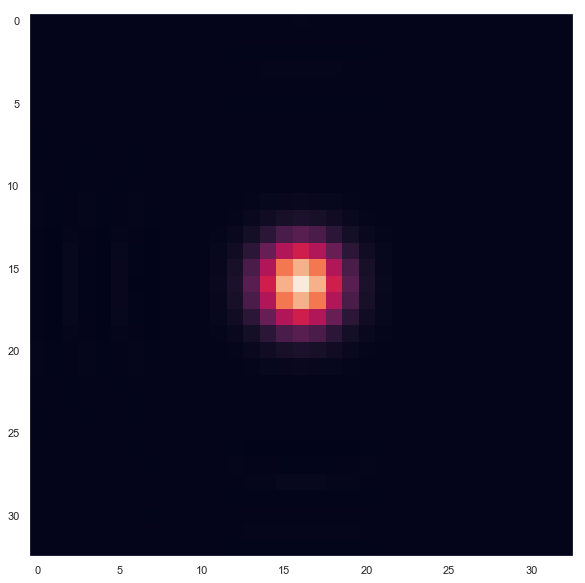

In [226]:
def _comp_fwhm(im):
    rowc = int((160 - 1)/2+1)
    colc_left = int(rowc - 12/SCALE-0.5)
    colc_right = int(rowc + 12/SCALE+0.5)
    
    im_left = im[rowc-16:rowc+16+1, colc_left-16:colc_left+16+1]
    im_right = im[rowc-16:rowc+16+1, colc_right-16:colc_right+16+1]
    
    print(galsim.ImageD(im_left, scale=SCALE).calculateFWHM())
    print(galsim.ImageD(im_right, scale=SCALE).calculateFWHM())
    
    return im_left, im_right

iml, imr = _comp_fwhm(imh)
plt.figure(figsize=(10, 10))
plt.imshow(imr)
plt.gca().grid(False)

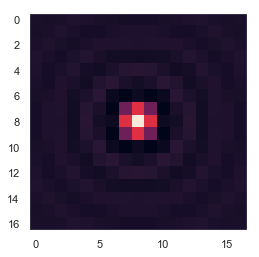

In [210]:
plt.figure()
plt.imshow(hpsf.get_kernel(0, 0))
plt.gca().grid(False)

## Original Code

In [143]:
def psf_model_galsim(row, col):
    if col >= 160/2:
        return galsim.InterpolatedImage(
            galsim.Gaussian(fwhm=1.0).drawImage(scale=SCALE, nx=17, ny=17, method=DRAW_METH),
            wcs=galsim.PixelScale(1))
    else:
        return galsim.InterpolatedImage(
            galsim.Gaussian(fwhm=PSF_FAC).drawImage(scale=SCALE, nx=17, ny=17, method=DRAW_METH),
            wcs=galsim.PixelScale(1))

import tqdm

def homogenize_galsim(image, target_psf, psf_model_galsim, sigma=0.1, patch_size=17):
    tgt = galsim.Convolve(target_psf, galsim.Gaussian(sigma=sigma))
    patch_size_2 = (patch_size - 1) // 2
    nrows, ncols = image.shape
    himage = np.zeros_like(image)
    pimage = np.pad(image, patch_size_2, 'constant')
    with tqdm.tqdm(range(nrows)) as itrr:
        for row in itrr:  
            for col in range(ncols):
                patch = galsim.InterpolatedImage(
                    galsim.ImageD(pimage[row:row+patch_size, col:col+patch_size].copy()),
                    wcs=galsim.PixelScale(1.0))

                kern = galsim.Convolve(tgt, galsim.Deconvolve(psf_model_galsim(row, col)))
                hpatch = galsim.Convolve(patch, kern).drawImage(
                    nx=patch_size, ny=patch_size, wcs=galsim.PixelScale(1), method='no_pixel')
                himage[row, col] = hpatch.array[patch_size_2, patch_size_2]
    return himage

In [144]:
%%time

im_orig = galsim.Sum(pobj).drawImage(scale=SCALE, nx=160, ny=160, method=DRAW_METH).array
target_psf = psf_model_galsim(16, 160)
imh = homogenize_galsim(im_orig, target_psf, psf_model_galsim)

100%|██████████| 160/160 [04:14<00:00,  1.56s/it]

CPU times: user 4min 1s, sys: 2.77 s, total: 4min 4s
Wall time: 4min 14s


Text(0.5, 1.0, 'image')

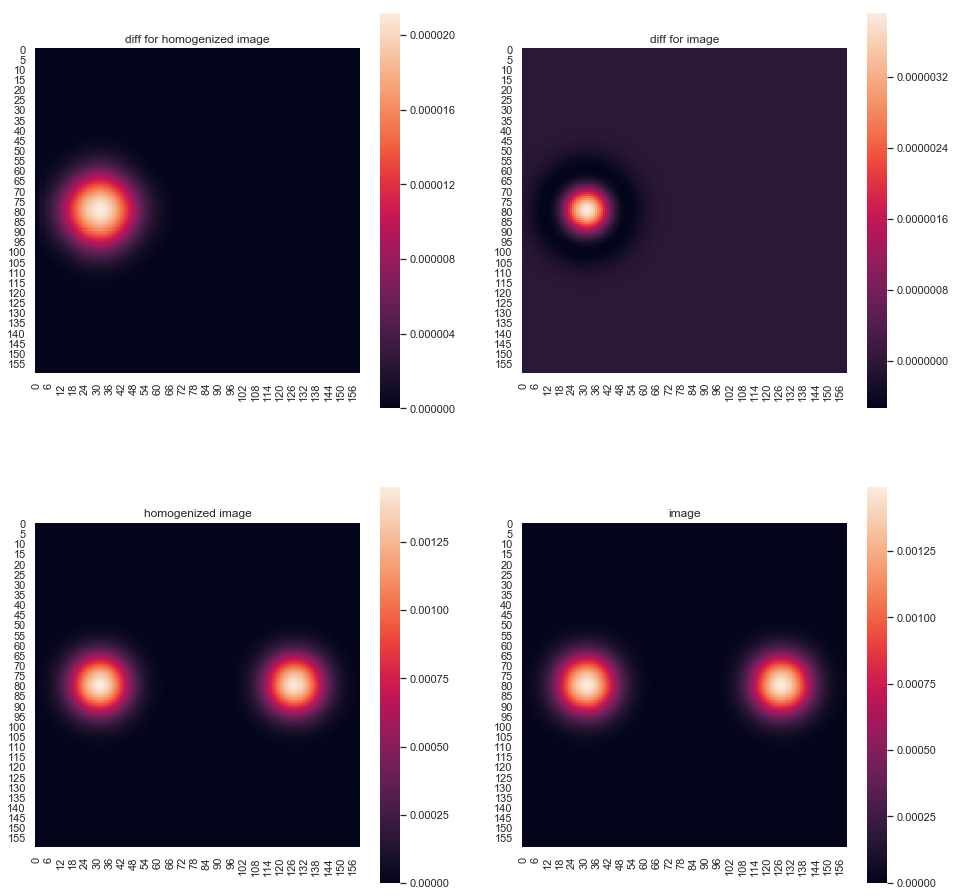

In [147]:
def _subtract_mirrored(im, im_true):
    imn = np.zeros_like(im)
    mid = imn.shape[1] // 2
    imn[:, :mid] = im[:, :mid] - im_true[:, mid:][:, ::-1]
    imn[:, mid:] = im[:, mid:] - im_true[:, mid:]
    return imn


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax = axs[0, 1]
imp = _subtract_mirrored(im_orig, im_orig)
vmin = np.min(imp)
vmax = np.max(imp)
# imp = (imp - vmin) / (vmax - vmin)
imp = imp #/ im_orig.max()
sns.heatmap(imp, ax=ax, square=True)
ax.grid(False)
ax.set_title('diff for image')

ax = axs[0, 0]
imp = _subtract_mirrored(imh, imh)
imp = (imp) #/imh.max() #/(vmax - vmin)
sns.heatmap(imp, ax=ax, square=True)
ax.set_title('diff for homogenized image')

ax = axs[1, 0]
sns.heatmap(imh, ax=ax, square=True)
ax.set_title('homogenized image')

ax = axs[1, 1]
sns.heatmap(im_orig, ax=ax, square=True)
ax.set_title('image')